In [1]:
import os
import numpy as np
import nibabel as nib
from glob import glob
from nilearn.masking import apply_mask, unmask
from nilearn.maskers import NiftiMasker
from nilearn import image
from tqdm import tqdm

def load_subj_mask(subject, session):
    mask_fn = f'/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/atlas/sub-{subject}_ses-{session}_task-trailer_part-mag_atlas-cit168_desc-brain_mask.nii.gz'
    brainmask_nii = nib.load(mask_fn)
    brainmask_data = brainmask_nii.get_fdata().astype(np.int32)
    brainmask_nii_updated = nib.Nifti1Image(brainmask_data, brainmask_nii.affine)
    return brainmask_nii_updated

subject = 'Damy001'
sessions = [1, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8]
fmri_data = [nib.load(f"/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/preproc/sub-{subject}_ses-{session}_task-trailer_part-mag_recon-preproc_bold.nii.gz") for session in sessions]

# Extract time series for each session
time_series = []
for session, data in zip(sessions, tqdm(fmri_data, desc="Extracting time series")):
    mask_nii = load_subj_mask(subject, session)
    masker = NiftiMasker(mask_img=mask_nii)
    masker.fit(data)
    time_series.append(masker.transform(data))
    
    



/home/zdiamand/.local/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
Extracting time series:  92%|█████████▏| 11/12 [07:29<00:40, 40.91s/it]


/home/zdiamand/.local/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


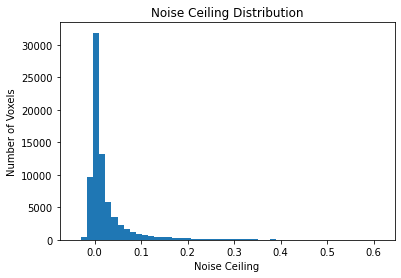

In [2]:
def noise_ceiling_estimation(time_series):
    n_sessions = len(time_series)
    n_voxels = time_series[0].shape[1]
    n_pairs = n_sessions * (n_sessions - 1) // 2

    # Compute pairwise correlations for each voxel
    pairwise_correlations = np.zeros((n_voxels, n_pairs))
    for voxel in range(n_voxels):
        pair_idx = 0
        for session1, session2 in itertools.combinations(range(n_sessions), 2):
            correlation, _ = pearsonr(time_series[session1][:, voxel], time_series[session2][:, voxel])
            pairwise_correlations[voxel, pair_idx] = correlation
            pair_idx += 1

    # Calculate the noise ceiling for each voxel
    noise_ceiling = np.mean(pairwise_correlations, axis=1)

    return noise_ceiling

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import itertools 
noise_ceiling = noise_ceiling_estimation(time_series)
# Plot histogram of noise ceiling values
plt.figure()
plt.hist(noise_ceiling, bins=50)
plt.xlabel('Noise Ceiling')
plt.ylabel('Number of Voxels')
plt.title('Noise Ceiling Distribution')
plt.show()



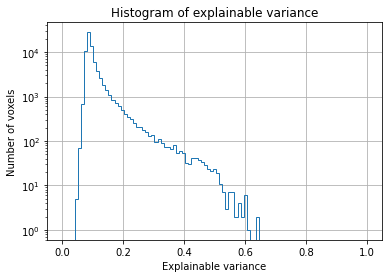

In [3]:
import scipy
time_series_array = np.stack(time_series, axis=0)
def explainable_variance(data, bias_correction=False, do_zscore=True):
    """Compute explainable variance for a set of voxels."""
    if do_zscore:
        data = scipy.stats.zscore(data, axis=1)

    mean_var = data.var(axis=1, dtype=np.float64, ddof=1).mean(axis=0)
    var_mean = data.mean(axis=0).var(axis=0, dtype=np.float64, ddof=1)
    ev = var_mean / mean_var

    if bias_correction:
        n_repeats = data.shape[0]
        ev = ev - (1 - ev) / (n_repeats - 1)
    return ev

ev = explainable_variance(time_series_array)
ev_no_na = ev[np.isfinite(ev)]

plt.hist(ev_no_na, bins=np.linspace(0, 1, 100), log=True, histtype='step')
plt.xlabel("Explainable variance")
plt.ylabel("Number of voxels")
plt.title('Histogram of explainable variance')
plt.grid('on')
plt.show()


In [4]:
print("(n_repeats, n_samples_test, n_voxels) =", time_series_array.shape)

(n_repeats, n_samples_test, n_voxels) = (12, 549, 186869)


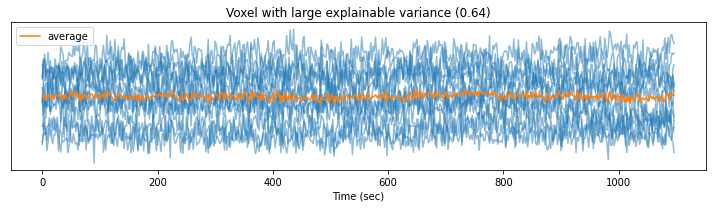

In [5]:
voxel_1 = np.argmax(ev_no_na)
time = np.arange(time_series_array.shape[1]) * 2  # one time point every 2 seconds
plt.figure(figsize=(10, 3))
plt.plot(time, time_series_array[:, :, voxel_1].T, color='C0', alpha=0.5)
plt.plot(time, time_series_array[:, :, voxel_1].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title("Voxel with large explainable variance (%.2f)" % ev_no_na[voxel_1])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

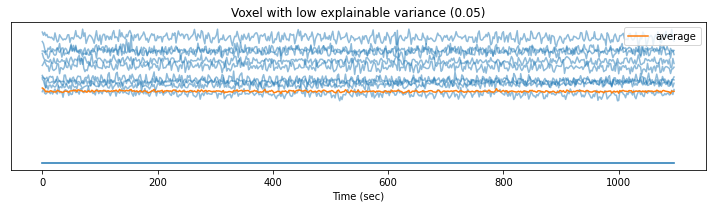

In [6]:
# Find the indices of voxels with non-zero time series
non_zero_ts_indices = np.nonzero(time_series_array.mean(axis=1).sum(axis=0) != 0)[0]

# Find the indices of voxels with non-zero explainable variance
non_zero_ev_indices = np.nonzero(ev_no_na > 0)[0]

# Find the common indices between non_zero_ts_indices and non_zero_ev_indices
common_indices = np.intersect1d(non_zero_ts_indices, non_zero_ev_indices)

# Find the index of the voxel with the lowest non-zero explainable variance and non-zero time series among the common_indices
voxel_2 = common_indices[np.argmin(ev_no_na[common_indices])]

# Create the plot
plt.figure(figsize=(10, 3))

# Plot individual time series for the voxel with the lowest non-zero explainable variance and non-zero time series
plt.plot(time, time_series_array[:, :, voxel_2].T, color='C0', alpha=0.5)

# Plot the average time series for the voxel with the lowest non-zero explainable variance and non-zero time series
plt.plot(time, time_series_array[:, :, voxel_2].mean(axis=0), color='C1', label='average')

# Set labels, title, and legend
plt.xlabel("Time (sec)")
plt.title("Voxel with low explainable variance (%.2f)" % ev_no_na[voxel_2])
plt.yticks([])
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


/home/zdiamand/.local/lib/python3.7/site-packages/nilearn/_utils/niimg.py:64: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


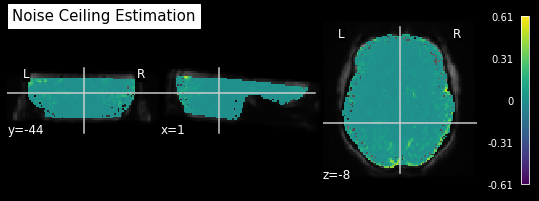

In [7]:
# Compute the mean EPI image
mean_epi_img = image.mean_img(fmri_data)
from nilearn import plotting

# Convert the noise ceiling values back to a brain volume
noise_ceiling_img = masker.inverse_transform(noise_ceiling)

# Visualize the spatial distribution of noise ceiling values
noise_ceiling_plot = plotting.plot_stat_map(noise_ceiling_img, bg_img=mean_epi_img, threshold=0, title='Noise Ceiling Estimation', cmap='viridis')
plt.show()


/home/zdiamand/.local/lib/python3.7/site-packages/nilearn/_utils/niimg.py:64: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


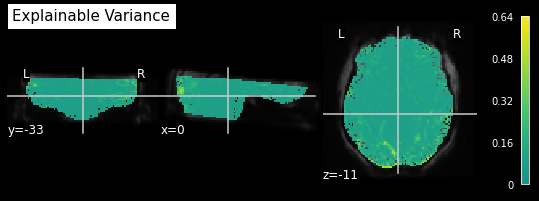

In [8]:
# Convert the explainable variance values back to a brain volume
ev_img = masker.inverse_transform(ev)

# Visualize the spatial distribution of explainable variance values
ev_plot = plotting.plot_stat_map(ev_img, bg_img=mean_epi_img, threshold=0, title='Explainable Variance', cmap='viridis')
plt.show()


/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


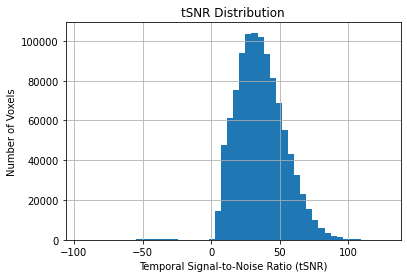

In [10]:
def calculate_tsnr(time_series_array):
    """Calculate temporal signal-to-noise ratio for a set of voxels."""
    mean_signal = np.mean(time_series_array, axis=1)
    std_signal = np.std(time_series_array, axis=1)
    tsnr = mean_signal / std_signal
    return tsnr

tsnr = calculate_tsnr(time_series_array)
tsnr_no_na = tsnr[np.isfinite(tsnr)]

# Plot histogram of tSNR values
plt.figure()
plt.hist(tsnr_no_na, bins=50)
plt.xlabel('Temporal Signal-to-Noise Ratio (tSNR)')
plt.ylabel('Number of Voxels')
plt.title('tSNR Distribution')
plt.grid('on')
plt.show()




/home/zdiamand/.local/lib/python3.7/site-packages/nilearn/_utils/niimg.py:64: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


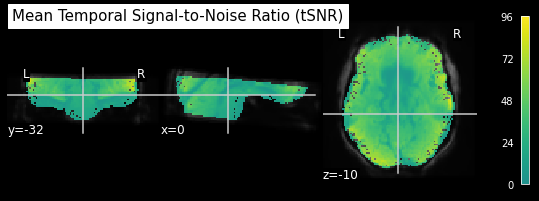

In [17]:
# Calculate the mean tSNR across sessions
mean_tsnr = np.mean(tsnr, axis=0)

# Convert the mean tSNR values back to a brain volume
mean_tsnr_img = masker.inverse_transform(mean_tsnr)

# Visualize the spatial distribution of mean tSNR values
mean_tsnr_plot = plotting.plot_stat_map(mean_tsnr_img, bg_img=mean_epi_img, threshold=0, title='Mean Temporal Signal-to-Noise Ratio (tSNR)', cmap='viridis')
plt.show()


# Alternative tSNR approach with conjunction mask - ignore for now

In [9]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
from nilearn.maskers import NiftiMasker
from tqdm import tqdm

def load_conjunction_mask(subject, sessions):
    mask_fns = [f'/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/atlas/sub-{subject}_ses-{session}_task-trailer_part-mag_atlas-cit168_desc-brain_mask.nii.gz' for session in sessions]
    brainmask = 1.0
    for mask_fn in mask_fns:
        bm = nib.load(mask_fn).get_fdata()
        brainmask *= bm
    return brainmask.astype(bool)

subjects = ['Damy001'] #Damy002 is missing files 
sessions = [1, 12, 13, 14, 15, 2, 3, 4, 5, 6, 7, 8]

tsnr_subject = []

for subject in subjects:
    # Load fMRI data for all sessions
    fmri_data = [nib.load(f"/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/preproc/sub-{subject}_ses-{session}_task-trailer_part-mag_recon-preproc_bold.nii.gz") for session in sessions]
    combined_data = nib.concat_images(fmri_data)
    
    # Calculate the tSNR
    tsnr = combined_data.get_fdata().mean(axis=3) / combined_data.get_fdata().std(axis=3)
    
    # Create the conjunction mask
    conjunction_mask = load_conjunction_mask(subject, sessions)
    
    # Extract tSNR values within the conjunction mask
    tsnr_subject.append(tsnr[conjunction_mask])




/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


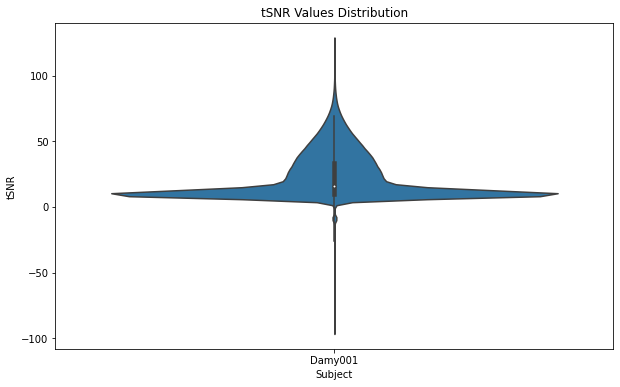

In [10]:
import seaborn as sns

# Create a violin plot of the tSNR values
plt.figure(figsize=(10, 6))
sns.violinplot(data=tsnr_subject)
plt.title('tSNR Values Distribution')
plt.xlabel('Subject')
plt.ylabel('tSNR')
plt.xticks(range(len(subjects)), subjects)

# Show the plot
plt.show()
